In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.optim as optim
import numpy as np

In [2]:
# def dataExtraction(params):
#     transform = transforms.Compose([
#     transforms.CenterCrop(160),
#     transforms.ToTensor()])
#     img = datasets.ImageFolder(root='asl_alphabets/gan_train/',
#                                transform=transform)
#     dataload = torch.utils.data.DataLoader(img,**params)
#     return dataload

In [3]:
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 6}
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0],[1])
])
data = datasets.FashionMNIST(root = 'data',train=True,download=True,
                                           transform=transform)
loader = torch.utils.data.DataLoader(data,**params)

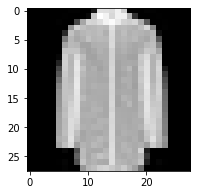

In [4]:
x,_= next(iter(loader))
x = x.numpy()
img = np.squeeze(x[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
# plt.imshow(np.transpose(x[0].numpy(), (1, 2, 0)))

In [5]:
class pixelNormalization(nn.Module):
    def __init__(self):
        super(pixelNormalization,self).__init__()
        
    def forward(self,x):
        eps = 1e-8
        batch, dim = x.shape[0], x.shape[1]
        if dim == 1:
            return x
        y,z = x.shape[2] , x.shape[3]
        x = x.view(batch,dim,-1)
        x_p = x/torch.sqrt(((1/dim)*x.sum(1)**2)+eps)
        x_p = x_p.view(batch,dim,y,z)
        return x_p

In [6]:
def tconv_section(inp,out,*args,**kargs):
    return nn.Sequential(
        nn.ConvTranspose2d(inp,out,*args,**kargs),
        pixelNormalization(),
#          nn.BatchNorm2d(out),
        nn.LeakyReLU(negative_slope=0.1)
    )
def tconv_block(a,*args,**kargs):
    layers = [tconv_section(i,j,*args,**kargs) for i,j in zip(a,a[1:])]
    return nn.Sequential(*layers)

In [7]:
tconv_block([1,16,16], kernel_size=3, padding=1)

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): pixelNormalization()
    (2): LeakyReLU(negative_slope=0.1)
  )
  (1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): pixelNormalization()
    (2): LeakyReLU(negative_slope=0.1)
  )
)

In [8]:
def to_rgb(in_size,*args,**kargs):
    out =1
    return nn.Sequential(
        nn.ConvTranspose2d(in_size,out,*args,**kargs),
#         pixelNormalization(),
#          nn.BatchNorm2d(out),
        nn.LeakyReLU(negative_slope=0.1)
    )

In [9]:
# weights
def init_weights(x,mean=0,std=1):
    i = x.__class__.__name__
    if (i == 'Conv2d' or i == 'Linear' or i == 'ConvTranspose2d'):
        nn.init.normal_(x.weight.data, mean=mean, std=std)

# var = 2/fan_in version of initialization - https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528
def he_initialization(x):
    i = x.__class__.__name__
    if (i == 'Conv2d' or i == 'ConvTranspose2d'):
        x.weight*(math.sqrt(2/(x.weight.shape[1]*x.weight.shape[2]*x.weight.shape[3])))
    elif (i == 'Linear'):
        x.weight*(math.sqrt(2/x.weight.shape[1]))
        
def scale(x, feature_range=(-1, 1)):
    x = x*(feature_range[1] - feature_range[0]) + feature_range[0]
    return x

In [10]:
class Generator(nn.Module):
    def __init__(self,z_size=100):
        super(Generator,self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(z_size,49),
            nn.ReLU()
        )
        self.dict = nn.ModuleDict({
            'layer_1': tconv_block([1,32,32], kernel_size=3, padding=1),
            'Upsample': nn.Upsample(scale_factor=2, mode='nearest'),
            'to_rgb_1': to_rgb(32,kernel_size=3, padding=1)
        })
    def grow(self,n,args):
        self.dict['layer_{}'.format(n)] = tconv_block(args, kernel_size=3, padding=1)
        self.dict['to_rgb_{}'.format(n)] = to_rgb(args[-1], kernel_size=3, padding=1)
        self.dict['layer_{}'.format(n)].apply(init_weights)
        self.dict['to_rgb_{}'.format(n)].apply(init_weights)
    
    def train_g(self,x,n,aplha):
        self.dict.apply(he_initialization)
        batch_size = x.shape[0]
        x = self.linear(x)
        x = x.view(batch_size,1,7,7)
        for i in range(n):
            if i == 0:
                x = self.dict['layer_{}'.format(i+1)](x)
#                 x = pixelNormalization(x)
                if n == 1:
                    x = self.dict['to_rgb_{}'.format(i+1)](x)
            elif i+1 == n:
                x = self.dict['Upsample'](x)
                out = self.dict['layer_{}'.format(i+1)](x)
                out = self.dict['to_rgb_{}'.format(i+1)](out)
#                 out = pixelNormalization(out)
                x = self.dict['to_rgb_{}'.format(i)](x)
#                 x = pixelNormalization(x)
                x = (1-aplha)*x + aplha*(out)
            else:
                x = self.dict['Upsample'](x)
                x = self.dict['layer_{}'.format(i+1)](x)
#                 x = pixelNormalization(x)
            x = torch.tanh(x)
        return x
                
    def forward(self,x,n):
        batch_size = x.shape[0]
        x = self.linear(x)
        x = x.view(batch_size,1,7,7)
        
        for i in range(n):
            if i == 0:
                x = self.dict['layer_{}'.format(i+1)](x)
            else:
                x = self.dict['Upsample'](x)
                x = self.dict['layer_{}'.format(i+1)](x)
                
        return x

In [11]:
def conv_section(inp,out,*args,**kargs):
    return nn.Sequential(
        nn.Conv2d(inp,out,*args,**kargs),
        pixelNormalization(),
#         nn.BatchNorm2d(out),
        nn.LeakyReLU(negative_slope=0.1)
    )
def conv_block(a,*args,**kargs):
    layers = [conv_section(i,j,*args,**kargs) for i,j in zip(a,a[1:])]
    return nn.Sequential(*layers)

def from_rgb(out,*args,**kargs):
    in_size = 1
    return nn.Sequential(
        nn.Conv2d(in_size,out,*args,**kargs),
        pixelNormalization(),
#         nn.BatchNorm2d(out),
        nn.LeakyReLU(negative_slope=0.1)
    )

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.down = nn.AvgPool2d(kernel_size=2)
        self.dict = nn.ModuleDict({
            'layer_1': conv_block([(32+1),32,1], kernel_size=3, padding=1),# account for minbatch stddev
            'Upsample': nn.Upsample(scale_factor=2, mode='nearest'),
            'from_rgb_1': from_rgb(32,kernel_size=3, padding=1)
        })
        self.linear = nn.Sequential(
            nn.Linear(49,1)
#             nn.Linear(10,1)
        )
#         self.sigmoid = nn.Sigmoid()
        
    def grow(self,n,args):
        rgb = args[0] 
        self.dict['layer_{}'.format(n)] = conv_block(args, kernel_size=3, padding=1)
        self.dict['from_rgb_{}'.format(n)] = from_rgb(rgb, kernel_size=3, padding=1)
        self.dict['layer_{}'.format(n)].apply(init_weights)
        self.dict['from_rgb_{}'.format(n)].apply(init_weights)
        
    def train_d(self,x,n,alpha):
        self.dict.apply(he_initialization)
        for i in range(n,0,-1):
            if n == 1:
                x = self.dict['from_rgb_{}'.format(n)](x)
                x = self.min_batch_stddev(x)
                x = self.dict['layer_{}'.format(n)](x)
            elif i == n:
                store = self.dict['from_rgb_{}'.format(n-1)](self.down(x))
                x = self.dict['from_rgb_{}'.format(n)](x)
                x = self.dict['layer_{}'.format(n)](x)
                x = self.down(x)
            elif i == n-1:
                x = (1-alpha)*x + alpha*(store)
                if i == 1:
                    x = self.min_batch_stddev(x)
                x = self.dict['layer_{}'.format(i)](x)
            else:
                if i == 1:
                    x = self.min_batch_stddev(x)
                x = self.dict['layer_{}'.format(i)](x)
                x = self.down(x)
        
        x = x.view(-1,49)
        x = self.linear(x)
                
        return x
    
    def downSample(self,x,n):
        if n < 0:
            return x
        for i in range(n):
            x = self.down(x)
            
        return x
    def min_batch_stddev(self,x):
#         min batch standard deviation pixel-wise std
        y,z = x.shape[2],x.shape[3]
        batch = x.shape[0]
        x = x.view(batch,x.shape[1],-1)
        dev = x.std(1)
        dev = dev.view(batch,1,-1)
        x = torch.cat([x,dev],1)
        x = x.view(-1,x.shape[1],y,z)
        return x
                

In [13]:
D = Discriminator()
D.apply(init_weights)

Discriminator(
  (down): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (dict): ModuleDict(
    (Upsample): Upsample(scale_factor=2.0, mode=nearest)
    (from_rgb_1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): pixelNormalization()
      (2): LeakyReLU(negative_slope=0.1)
    )
    (layer_1): Sequential(
      (0): Sequential(
        (0): Conv2d(33, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): pixelNormalization()
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): Sequential(
        (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): pixelNormalization()
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
  )
  (linear): Sequential(
    (0): Linear(in_features=49, out_features=1, bias=True)
  )
)

In [14]:
G = Generator()
G.apply(init_weights)

Generator(
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=49, bias=True)
    (1): ReLU()
  )
  (dict): ModuleDict(
    (Upsample): Upsample(scale_factor=2.0, mode=nearest)
    (layer_1): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): pixelNormalization()
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): Sequential(
        (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): pixelNormalization()
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (to_rgb_1): Sequential(
      (0): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
  )
)

## loss function

In [15]:
# def real_loss(x,smooth=False):
#     x = torch.relu(x)
#     if smooth == True:
#         loss = torch.mean(torch.abs(x - 0.9))
#     else:
#         loss = torch.mean(torch.abs(x - 1))
        
#     return loss

# def fake_loss(x):
#     x = torch.relu(x)
#     loss = torch.mean(torch.abs(x - 0.1))
#     return loss

In [16]:
def real_loss(D_out,smooth = False):
    batch_size = D_out.size(0)
    if smooth:
        labels =torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
        
    if torch.cuda.is_available:
        labels = labels.cuda()
        
    crit = nn.BCEWithLogitsLoss()
    loss = crit(D_out.squeeze(),labels)
    return loss
def fake_loss(D_out):
    labels = torch.ones(D_out.size(0))*0.1
    crit = nn.BCEWithLogitsLoss()
    
    if torch.cuda.is_available:
        labels = labels.cuda()
        
    loss = crit(D_out.squeeze(),labels)
    return loss

### Growth dimmensions

In [17]:
g_dim = [[32,32,32,32],[32,32,32,32]]
d_dim = [[32,32,32,32,32],[32,32,32,32,32]]
# down sampling times
down_times = [2,1,0]
# epochs 
epochs = [35,35,35]

In [18]:
lr = 0.0002
beta1=0.3
beta2=0.999  
test = np.random.normal(0,1,size=(params['batch_size'],100)) #torch.randn(16,100)
test = torch.from_numpy(test).float()
losses =[]
j =0 
for i in range(1,4):
    print('Starting the {} level'.format(i))
    if i != 1:
        D.grow(i,d_dim[j])
        G.grow(i,g_dim[j])
        j +=1
    # Create optimizers for the discriminator D and generator G
    d_optimizer = optim.Adam(D.parameters(),lr=lr,betas=[beta1, beta2])
    g_optimizer = optim.Adam(G.parameters(),lr=lr*beta2,betas=[beta1, beta2])
    if torch.cuda.is_available:
        G.cuda()
        D.cuda()
    for e in range(epochs[i-1]):
        alpha = (e+1)/epochs[i-1]
        for x,_ in loader:
            if torch.cuda.is_available:
                x = x.cuda()
            d_optimizer.zero_grad()
            # real
            x = D.downSample(x,down_times[i-1])
            out_real = D.train_d(x,i,alpha)
            d_real = -1*torch.mean(out_real) #real_loss(out_real,smooth=True)
            # fake
            z = np.random.normal(0,1,size=(params['batch_size'],100))
            z= torch.from_numpy(z).float()
            if torch.cuda.is_available:
                z = z.cuda()
            out_fake = G.train_g(z,i,alpha)
            out_fake = D.train_d(out_fake,i,alpha)
            d_fake = torch.mean(out_fake)
            
            d_loss = d_real+d_fake
            d_loss.backward()
            d_optimizer.step()
            # generator
            g_optimizer.zero_grad()
            
            z = np.random.normal(0,1,size=(params['batch_size'],100))
            z= torch.from_numpy(z).float()
            if torch.cuda.is_available:
                z = z.cuda()
            out_g = G.train_g(z,i,alpha)
            out_g = D.train_d(out_g,i,alpha)
            g_loss = -1*torch.mean(out_g)
            
            g_loss.backward()
            g_optimizer.step()
        else:
            if e %1 == 0:
                losses.append((d_loss.item(),g_loss.item()))
                print('Epoch/Phase :{}/{} : The Discriminator loss = {:6.4f} || The Generator loss = {:6.4f}'.format(e,i,d_loss.item(),g_loss.item()))
#     else:
#         G.eval()
#         if torch.cuda.is_available:
#             test = test.cuda()
#         img = G.train_g(test,i,1)
#         G.train()
#         img = img.cpu().detach()
#         plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))

Starting the 1 level
Epoch/Phase :0/1 : The Discriminator loss = 5277.4551 || The Generator loss = 35781.4102
Epoch/Phase :1/1 : The Discriminator loss = -1426.0662 || The Generator loss = 2239.0029
Epoch/Phase :2/1 : The Discriminator loss = 3432.6562 || The Generator loss = -923.4218
Epoch/Phase :3/1 : The Discriminator loss = 1856.2622 || The Generator loss = 1496.0721
Epoch/Phase :4/1 : The Discriminator loss = 348.9370 || The Generator loss = -549.9196
Epoch/Phase :5/1 : The Discriminator loss = 1836.6812 || The Generator loss = 57.0834
Epoch/Phase :6/1 : The Discriminator loss = 4586.9189 || The Generator loss = 378.6982
Epoch/Phase :7/1 : The Discriminator loss = 62.2992 || The Generator loss = -1564.3484
Epoch/Phase :8/1 : The Discriminator loss = -533.1854 || The Generator loss = 8252.7051
Epoch/Phase :9/1 : The Discriminator loss = 5634.5859 || The Generator loss = 1136.9800
Epoch/Phase :10/1 : The Discriminator loss = -673.7607 || The Generator loss = 16516.1973
Epoch/Phase 

Epoch/Phase :21/3 : The Discriminator loss = -6753.5664 || The Generator loss = 32851.6328
Epoch/Phase :22/3 : The Discriminator loss = -13059.4033 || The Generator loss = -1153.4585
Epoch/Phase :23/3 : The Discriminator loss = 3874.8291 || The Generator loss = 448.7747
Epoch/Phase :24/3 : The Discriminator loss = -4038.9871 || The Generator loss = 2848.9956
Epoch/Phase :25/3 : The Discriminator loss = -8454.7803 || The Generator loss = 6677.7236
Epoch/Phase :26/3 : The Discriminator loss = -31631.6504 || The Generator loss = 4470.4248
Epoch/Phase :27/3 : The Discriminator loss = -2873.5654 || The Generator loss = -1887.8124
Epoch/Phase :28/3 : The Discriminator loss = 28391.0566 || The Generator loss = -2231.5117
Epoch/Phase :29/3 : The Discriminator loss = 15593.3828 || The Generator loss = 8351.9785
Epoch/Phase :30/3 : The Discriminator loss = -7242.0962 || The Generator loss = -1923.0392
Epoch/Phase :31/3 : The Discriminator loss = 543.5820 || The Generator loss = -9063.8809
Epoch/

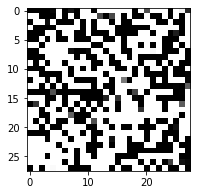

In [19]:
G.eval()
if torch.cuda.is_available:
        test = test.cuda()
img = G.train_g(test,3,1)
G.train()
imge = img.cpu().detach().numpy()
img = np.squeeze(imge[2])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
# plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))

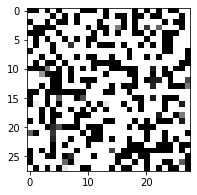

In [20]:
img = np.squeeze(imge[23])
fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')